# Variant calling with bcftools or custom function

- Bcftools creates pileup from bam file, which in our case was generated using minimap2. To the variant calling, custom thresholds can be set.

### Goal of the analysis

- Identify variants based on quality (e.g Phred quality score) & Alignment frequency
- If there are multiple variants, check which occur together and which are seperated (mixed population).
- Check if the variant is an actual variant or sequencing error


In [2]:
import sys
import os
import importlib
import pandas as pd
import numpy as np
import seaborn as sns
import pysam 
import subprocess
from pathlib import Path
from uncertainties import ufloat
from collections import Counter
from matplotlib import pyplot as plt
from itertools import combinations
from scipy.stats import chi2_contingency, fisher_exact
from sklearn.metrics import jaccard_score


sys.path.append("/home/emre/github_repo/MinION")

from minION import analyser
from minION import consensus
from minION.util import IO_processor
importlib.reload(IO_processor)
importlib.reload(analyser)
importlib.reload(consensus)

<module 'minION.consensus' from '/home/emre/github_repo/MinION/minION/consensus.py'>

In [11]:
def call_and_filter_vcf(input_path, reference, allele_frequency):
    """ Uses bcftools to call variants and filter them based on allele frequency.
    Args:
        - input_path (str): Path to the input files.
        - reference (str): Path to the reference genome.
        - allele_frequency (float): Allele frequency threshold.
    Returns:
        - Subprocess run
    """
    
    
    prompt_pileup = f"bcftools mpileup -d 4000 -Ou -f {reference}  {input_path}/alignment.bam > {input_path}/pileup.bcf"

    prompt_call = f"bcftools call -mv -Ob -o {input_path}/raw_variants.bcf {input_path}/pileup.bcf"

    prompt_view = f"bcftools view -i 'INFO/AF>{allele_frequency}' -Ob -o {input_path}/filtered_variants.vcf {input_path}/raw_variants.bcf"


    subprocess.run(prompt_pileup, shell=True)

    subprocess.run(prompt_call, shell=True)

    subprocess.run(prompt_view, shell=True)

    print(f"Variant calling and filtering completed. Output saved to {input_path}/raw_variants_python.bcf")


def extract_positions_from_vcf(vcf_file : str) -> list:
    """ Extracts the positions of the variants from a VCF file.
    Args:
        - vcf_file (str): Path to the VCF file. 
    Returns:
        - positions (list): List of variant positions.
    """
    positions = []
 
    vcf = pysam.VariantFile(vcf_file)

    for record in vcf:
        positions.append(record.pos)
    
    vcf.close()

    return positions

def extract_mutations_from_vcf(vcf_file):
    """ Extracts the mutations from a VCF file.
    Args:
        - vcf_file (str): Path to the VCF file.
    Returns:
        - formatted_mutations (str): Formatted mutations (e.g A100T_G223C).
    """

    mutations = []

    vcf = pysam.VariantFile(vcf_file)

    for record in vcf:

        ref_allele = record.ref
        alt_alleles = record.alts

        for alt_allele in alt_alleles:
            position = record.pos
            mutation = f"{ref_allele}{position}{alt_allele}"
            mutations.append(mutation)

    vcf.close()

    formatted_mutations = "_".join(mutations)

    return formatted_mutations


def get_base_counts_at_position(bam_file, chrom, position):
    """
    Extract unique bases and gaps (deletions) and their counts from a BAM file 
    at a specific position using pileup.
    
    Args:
    - bam_file (str): path to the BAM file.
    - chrom (str): chromosome or contig name.
    - position (int): 1-based position to extract bases from.

    Returns:
    - dict: unique bases and gaps with their counts at the specified position.
    """
    
    bases = []

    
    with pysam.AlignmentFile(bam_file, 'rb') as bam:
        for pileup_column in bam.pileup(chrom, position - 1, position, 
                                        min_base_quality=0, 
                                        min_mapping_quality=0, 
                                        truncate=True):
            if pileup_column.pos == position - 1: 
                for pileup_read in pileup_column.pileups:
                    if pileup_read.is_del:
                        bases.append("-")  
                    elif not pileup_read.is_refskip:
                        bases.append(pileup_read.alignment.query_sequence[pileup_read.query_position])

    base_counts = Counter(bases)

    return base_counts


def generate_heatmap_data(bam_file, chrom, positions):
    data = []
    all_bases = set(['A', 'T', 'C', 'G', '-'])
    for position in positions:
        base_counts = get_base_counts_at_position(bam_file, chrom, position)
        col = [base_counts.get(base, 0) for base in all_bases]
        data.append(col)
    df = pd.DataFrame(data, index=positions, columns=list(all_bases))
    # Order as in all_bases
    # TODO: Specify if a character if it is an actual gap or no coverage
    df = df[['A', 'T', 'C', 'G', '-']]
    return df




def get_most_common_base(position, heatmap_data, ref_base):
    non_ref_data = heatmap_data.loc[position].drop(ref_base)
    return non_ref_data.idxmax(), non_ref_data.max()



def get_bases_from_pileup(bam_file, chrom, positions):
    bases_dict = {position: {} for position in positions}
    
    with pysam.AlignmentFile(bam_file, 'rb') as bam:
        for pileup_column in bam.pileup(chrom, min(positions) - 1, max(positions) + 1,
                                        min_base_quality=0, 
                                        min_mapping_quality=0, 
                                        truncate=True):
            if pileup_column.pos + 1 in positions:
                for pileup_read in pileup_column.pileups:
                    if not pileup_read.is_del and not pileup_read.is_refskip:
                        base = pileup_read.alignment.query_sequence[pileup_read.query_position]
                        read_name = pileup_read.alignment.query_name
                        # Check if the read name is already added to the bases_dict for that position
                        if read_name not in bases_dict[pileup_column.pos + 1]:
                            bases_dict[pileup_column.pos + 1][read_name] = base

    # Get unique read names and sort them to have a consistent order
    read_names = sorted(set().union(*[bases_dict[pos].keys() for pos in bases_dict]))

    # Create DataFrame
    df = pd.DataFrame(index=read_names, columns=positions)
    
    # Populate DataFrame
    for pos in positions:
        for read_name, base in bases_dict[pos].items():
            df.at[read_name, pos] = base
    
    # Fill NaN with "-"
    df = df.fillna("-")

    return df

def get_max_base_at_position(bam_file, chrom, position):
    base_counts = get_base_counts_at_position(bam_file, chrom, position)
    return base_counts.most_common(1)[0][0]

In [ ]:
get_base_counts_at_position

In [12]:
barcodes = IO_processor.get_barcode_dict(Path("/home/emre/minION_results/MinION_RBC_0902723_sup/Demultiplex_cpp_70_short"))
#path_to_bam = "/home/emre/minION_results/MinION_RBC_0902723_sup/Demultiplex_cpp_70_short/RB03/NB08/consensus"
path_to_bam = "/home/emre/minION_results/20231119_1502_MN41105/Demultiplex_cpp_70/RB01/NB22/consensus"
#template_fasta = "/home/emre/github_repo/MinION/minION/refseq/hetcpiii.fasta"
#template_fasta = Path("/home/emre/tam-lqv.fasta")
template_fasta = Path("/home/emre/PgA9.fasta")
#output_vcf = f"{path_to_bam}/raw_variants.vcf"
#consensus.get_consensus(Path(path_to_bam), Path(template_fasta))
#call_and_filter_vcf(path_to_bam, template_fasta, 0.4)
bam_file = f'{path_to_bam}/alignment.bam'

In [ ]:
extract_mutations_from_vcf(f'{path_to_bam}/filtered_variants.vcf')

In [ ]:
nb_positions = extract_positions_from_vcf(f'{path_to_bam}/filtered_variants.vcf')

In [14]:
#reference = "HetCPIII"
#reference = "Tam-LQV"
reference = "PgA9"  
position_to_check = 1  
bases_at_position = get_base_counts_at_position(bam_file, reference, position_to_check)
bases_at_position

Counter({'A': 396})

In [ ]:
#heatmap_data = generate_heatmap_data(bam_file, reference, 1, 100)
nb_positions = [23,38,56,98,421]
heatmap_data = generate_heatmap_data(bam_file, reference, nb_positions)

In [ ]:
heatmap_data

In [ ]:

template = analyser.get_template_sequence(template_fasta)

# Plotting
plt.figure(figsize=(7, 4))
sns.heatmap(heatmap_data, 
            annot=False, 
            cmap='YlGnBu', 
            cbar_kws={'label': 'Count'}, 
            linewidths=0.5, 
            linecolor='white')
plt.title("Base Counts per Position")
plt.xlabel("Bases")
plt.ylabel("Position")
plt.show()

In [ ]:
bam_file

### Get Highest Non Reference Base Frequency

- Bam file
- Reference sequence

In [15]:
ref_seq = analyser.get_template_sequence(template_fasta)
freq_dist = pd.DataFrame(analyser.get_highest_non_ref_base_freq(bam_file, reference, range(1,len(ref_seq)), ref_seq)[0]).T

In [ ]:
freq_dist

In [ ]:
# Replace NaN value with "T"
freq_dist[0] = freq_dist[0].fillna("None")

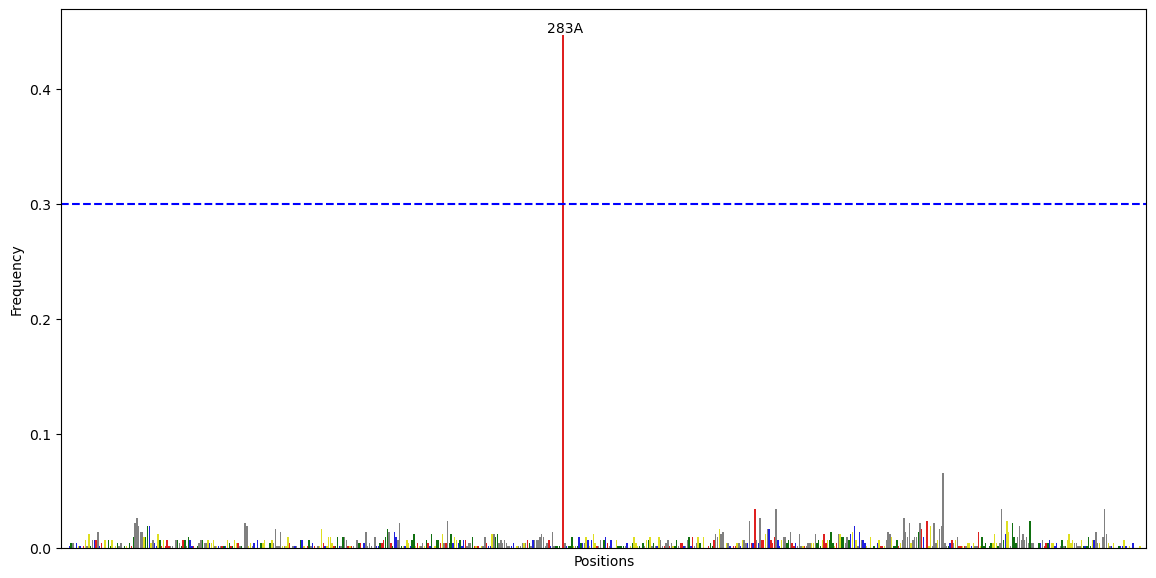

In [16]:
colors_for_bases = {"-" : "grey", "A" : "red", "T" : "blue", "C" : "green", "G" : "yellow", "None" : "black"}

freq_dist = freq_dist.rename(columns={0:"Base", 1:"Frequency"})

freq_dist["Base"] = freq_dist["Base"].fillna("None")

freq_dist = freq_dist.dropna()

freq_dist["Color"] = freq_dist["Base"].map(colors_for_bases)



# Plotting
plt.figure(figsize=(14, 7))
sns.barplot(x=freq_dist.index, y=freq_dist["Frequency"], palette=freq_dist["Color"])
#plt.title("Highest Non-Reference Base Frequency ")
plt.xticks([])
plt.xlabel("Positions")
plt.ylabel("Frequency")
# TODO Add horizontal line at 2 mean std deviation
plt.axhline(y=0.3, color='b', linestyle='--')
# TODO Add legend for bases
nb_positions = []
for index, row in freq_dist.iterrows():
    if row["Frequency"] > 0.3:
        nb_positions.append(index)
        plt.text(index, row["Frequency"], f"{index}{row['Base']}", color='black', ha="center", va='bottom')

plt.show()

#plt.savefig("/home/emre/github_repo/MinION/examples/figures/PgA9_variant_freq_RB02_NB92.png")


In [ ]:
def get_nb_positions(freq_dist, threshold):
    nb_positions = []
    for index, row in freq_dist.iterrows():
        if row["Frequency"] > threshold:
            nb_positions.append(index)
    return nb_positions

In [ ]:
bases_df = get_bases_from_pileup(bam_file, reference, nb_positions)

heatmap_data = generate_heatmap_data(bam_file, reference, nb_positions)
pval_matrix = np.zeros((len(nb_positions), len(nb_positions)))
odds_ratio_matrix = np.zeros((len(nb_positions), len(nb_positions)))
jaccard_index_matrix = np.zeros((len(nb_positions), len(nb_positions)))
overlap_matrix = np.zeros((len(nb_positions), len(nb_positions)))

In [ ]:
# Generate combinations of positions and initialize storage structures
variant = []
if nb_positions is not None:
    heatmap_data = generate_heatmap_data(bam_file, reference, nb_positions)
    position_combinations = list(combinations(nb_positions, 2))
    jaccard_indices = {"Pair": [],"Jaccard Index": [],}
    bases_df = get_bases_from_pileup(bam_file, reference, nb_positions)

    if len(nb_positions) == 1:

        variant = f"{template[nb_positions[0] - 1]}{nb_positions[0]}{get_most_common_base([0], heatmap_data, template[nb_positions[0] - 1])[0]}"


    elif len(nb_positions) > 1:
        # Process each pair of positions
        for pos1, pos2 in position_combinations:
            common_base1, common_base2 = [get_most_common_base(pos, heatmap_data, template[pos - 1])[0] for pos in [pos1, pos2]]
            ref_bases = [template[pos - 1] for pos in [pos1, pos2]]

            counts = {}
            for idx, (base1, base2) in enumerate([(common_base1, common_base2), (ref_bases[0], common_base2), (common_base1, ref_bases[1]), (ref_bases[0], ref_bases[1])]):
                counts[idx] = len(bases_df[(bases_df[pos1] == base1) & (bases_df[pos2] == base2)]) + 1

            # Calculate Jaccard indices
            jaccard_dict = {f"A_{i}_and_B_{j}": counts[k] / (counts[k] + counts[(k + 1) % 4] + counts[(k + 2) % 4]) for k, (i, j) in enumerate([('mut', 'mut'), ('wt', 'mut'), ('mut', 'wt'), ('wt', 'wt')])}

            jaccard_indices["Pair"].append((pos1, pos2))
            jaccard_indices["Jaccard Index"].append(jaccard_dict)

            jaccard_index_matrix[nb_positions.index(pos1), nb_positions.index(pos2)] = jaccard_dict["A_mut_and_B_mut"]

            contingency_table = pd.DataFrame({
                "mut_A": [jaccard_dict["A_mut_and_B_mut"], jaccard_dict["A_mut_and_B_wt"]],
                "wt_A": [jaccard_dict["A_wt_and_B_mut"], jaccard_dict["A_wt_and_B_wt"]],
            }, index=['mut_B', 'wt_B'])

        mutation_details = {"Type": [], "Position": [], "Variant": [], "Frequency": []}
        for i, (pair, jaccard_dict) in enumerate(zip(jaccard_indices["Pair"], jaccard_indices["Jaccard Index"])):
            max_type = max(jaccard_dict, key=jaccard_dict.get)
            if jaccard_dict[max(jaccard_dict, key=jaccard_dict.get)] > 0.7 and max_type != "A_wt_and_B_wt":

                ref_bases = [template[pos - 1] for pos in pair]
                common_base1, common_base2 = [get_most_common_base(pos, heatmap_data, template[pos - 1])[0] for pos in pair]
                if max_type == "A_mut_and_B_mut":
                    mutation_details["Type"].extend(["Co-Occuring"])
                    mutation_details["Position"].extend(pair)
                    mutation_details["Variant"].extend([f'{ref_bases[0]}{pair[0]}{common_base1}', f'{ref_bases[1]}{pair[1]}{common_base2}'])
                    mutation_details["Frequency"].extend([jaccard_dict["A_mut_and_B_mut"], jaccard_dict["A_mut_and_B_mut"]])
                elif max_type == "A_mut_and_B_wt":
                    mutation_details["Type"].extend(["A"])
                    mutation_details["Position"].append(pair[0])
                    mutation_details["Variant"].append(f'{ref_bases[0]}{pair[0]}{common_base1}')
                    mutation_details["Frequency"].append(jaccard_dict["A_mut_and_B_wt"])
                elif max_type == "A_wt_and_B_mut":
                    mutation_details["Type"].extend(["B"])
                    mutation_details["Position"].append(pair[1])
                    mutation_details["Variant"].append(f'{ref_bases[1]}{pair[1]}{common_base2}')
                    mutation_details["Frequency"].append(jaccard_dict["A_wt_and_B_mut"])
            


        # Create a DataFrame from the mutation details of Position and Variant only
        mutation_details_df = pd.DataFrame(mutation_details, columns=["Position", "Variant", "Frequency"])


        mutation_details_df = mutation_details_df.sort_values(by=["Position"])
        mutation_details_df = mutation_details_df["Variant"].drop_duplicates()

        # TODO: Try to explain why we set up a threshold of 10
        if len(mutation_details_df) > 10:
            variant = "NA"
        else:

            variant = "_".join(list(mutation_details_df))

        #Plot heatmap for Jaccard indices
        plt.figure(figsize=(6, 4))
        sns.heatmap(jaccard_index_matrix, cmap='coolwarm', mask=np.tri(len(nb_positions), k=-1), linewidths=0.5, linecolor='white')
        plt.xlabel('Position')
        plt.ylabel('Position')
        plt.title('Jaccard Index Heatmap')
else:
    variant = "#PARENT#"


In [ ]:
# Calculate the frequency of each unique row
frequency_df = bases_df.apply(lambda row: '-'.join(row), axis=1).value_counts().reset_index()
frequency_df.columns = ['Population', 'Frequency']
frequency_df["Frequency"] = frequency_df["Frequency"] / frequency_df["Frequency"].sum()

In [3]:
import tqdm

def get_variant_name(entry, reference, nb_positions):
    variant = []
    for i, mut in enumerate(entry):
        
        ref_AA = reference[nb_positions[i] - 1]
        
        if mut == "-":
            v = f'{ref_AA}{nb_positions[i]}DEL'
        
        elif mut == ref_AA:
            continue

        else:
            v = f'{ref_AA}{nb_positions[i]}{mut}'

        variant.append(v)

    return "_".join(variant)

def get_nb_positions(freq_dist, threshold):
    nb_positions = []
    for index, row in freq_dist.iterrows():
        if row["Frequency"] > threshold:
            nb_positions.append(index)
    return nb_positions

def get_pop_frequency(bam_file, template, reference, nb_positions, min_freq=0.1, min_depth= 15):

    # Get PileUP
    bases_df = get_bases_from_pileup(bam_file, reference, nb_positions)
    
    frequency_df = bases_df.apply(get_variant_name, axis=1, args=(template, nb_positions)).value_counts().reset_index()

    frequency_df.columns = ['Population', 'N_reads']
    
    frequency_df["Frequency"] = frequency_df["N_reads"] / frequency_df["N_reads"].sum()

    # Filter for frequency > 0.1
    frequency_df = frequency_df[(frequency_df["Frequency"] > min_freq) & (frequency_df["N_reads"] > min_depth)]

    return frequency_df

def call_variant_pop_frequency(bam_file, template, reference, min_freq=0.1, min_depth= 15):
    """ 
    Call Variant from BAM file based on Basecall Frequency & Alignment Frequency

    Args:
        - bam_file (str): Path to the BAM file.
        - template (str): Template name >NAME from fasta or fastq files.
        - reference (str): Reference name >NAME from fasta or fastq files.
        - nb_positions (list): List of positions to call variants.
        - min_freq (float): Minimum frequency of the variant.
        - min_depth (int): Minimum depth of the variant.
    
    Returns:
        - variant (str): Variant name.
    """

    variants = {"Variant" : [], "Position" : [], "Alignment Count" : [], "Alignment Frequency" : []}


    try:
        alignment_count = int(subprocess.run(f"samtools view -c {bam_file}", shell=True, capture_output=True).stdout.decode("utf-8").strip())
        freq_dist = pd.DataFrame(analyser.get_highest_non_ref_base_freq(bam_file, reference, range(1,len(template)), template)[0]).T.rename(columns={0:"Base", 1:"Frequency"})

        nb_positions = get_nb_positions(freq_dist, 0.4)

        if nb_positions == [] and alignment_count > min_depth:
            variants["Variant"].append("#PARENT#")
            variants["Position"].append("-")
            variants["Alignment Count"].append(alignment_count)
            variants["Alignment Frequency"].append("-")
            

        elif nb_positions == [] and alignment_count < min_depth:
            variants["Variant"].append("NA")
            variants["Position"].append("-")
            variants["Alignment Count"].append(alignment_count)
            variants["Alignment Frequency"].append("-")

        elif len(nb_positions) == 1 and alignment_count > min_depth:

            ref_base = template[nb_positions[0] - 1]
            pos = nb_positions[0]
            base = freq_dist["Base"][nb_positions[0] - 1]

            variants["Variant"].append(f"{ref_base}{pos}{base}")
            variants["Position"].append(nb_positions[0])
            variants["Alignment Count"].append(alignment_count)
            variants["Alignment Frequency"].append(freq_dist["Frequency"][nb_positions[0] - 1])

           
        else:

            freq_df = get_pop_frequency(bam_file, template, reference, nb_positions, min_freq=0.1)

            for index, row in freq_df.iterrows():
                variant = row["Population"]
                variants["Variant"].append(variant)
                variants["Position"].append(nb_positions)
                variants["Alignment Count"].append(row["N_reads"])
                variants["Alignment Frequency"].append(row["Frequency"])

    except:
        print("Error in calling variant")
        variants["Variant"].append("NA")
        variants["Position"].append("-")

    return variants

def get_variant_df_AF(demultiplex_folder: Path, ref_seq : Path, ref_name : str, barcode_dicts : dict = None, consensus_folder_name = "consensus", merge = True, min_freq=0.1, min_depth= 15):

    if barcode_dicts is None:
        barcode_dicts = IO_processor.get_barcode_dict(demultiplex_folder)
    
    variant_template_df = analyser.template_df(barcode_dicts, rowwise=False)

    variants = {"RBC": [], "FBC": [], "Position": [], "Variant": [], "Alignment Count": [], "Alignment Frequency": []}

    template = analyser.get_template_sequence(ref_seq) # Reference sequence

    summary = analyser.read_summary_file(demultiplex_folder)
    n_counts = summary.groupby(["RBC","FBC"])["FBC"].value_counts().reset_index() 



    for barcode_id, barcode_dict in barcode_dicts.items():

        rbc = os.path.basename(barcode_id)

        for front_barcode in barcode_dict:

            fbc = os.path.basename(front_barcode)

            count = n_counts[ (n_counts["RBC"] == rbc) & (n_counts["FBC"] == fbc)]["count"].values[0]

            bam_file = front_barcode / consensus_folder_name / "alignment.bam"

            if not bam_file.exists():
                print(f"{bam_file} does not exist.")
                variants["RBC"].append(rbc)
                variants["FBC"].append(fbc)
                variants["Position"].append(["NA"])
                variants["Variant"].append(["NA"])
                #variants["Reads"].append(count)
                variants["Alignment Count"].append(["NA"])
                variants["Alignment Frequency"].append(["NA"])
                continue

            try:
                
                nn_variants = call_variant_pop_frequency(bam_file, template, ref_name, min_freq, min_depth) # TODO read header from reference file for name

                for i, variant in enumerate(nn_variants["Variant"]):
                    variants["RBC"].append(rbc)
                    variants["FBC"].append(fbc)
                    variants["Position"].append(nn_variants["Position"][i])
                    variants["Variant"].append(variant)
                    #variants["Reads"].append(count)
                    variants["Alignment Count"].append(nn_variants["Alignment Count"][i])
                    variants["Alignment Frequency"].append(nn_variants["Alignment Frequency"][i])
            
            except:
                print(f"Skipping {rbc}/{fbc}")
                continue

    variant_df = analyser.rename_barcode(pd.DataFrame(variants).merge(n_counts, on=["RBC","FBC"] , how="left"))

    if merge:
        return variant_df.merge(variant_template_df, on=["Plate", "Well"], how="right")
    else:
        return variants



def get_mixed_population(variant_df):

    # Get row that are not unique
    mixed_pop = variant_df[variant_df.duplicated(subset=["Plate", "Well"], keep=False)]

    return mixed_pop



In [ ]:
path_to_bam = "/home/emre/minION_results/20231119_1502_MN41105/Demultiplex_cpp_70/RB01/NB94/consensus"
bam_file = f'{path_to_bam}/alignment.bam'
template = analyser.get_template_sequence(Path("/home/emre/PgA9.fasta"))
reference = "PgA9"


In [18]:
variant_df = get_variant_df_AF(Path("/home/emre/minION_results/20231119_1502_MN41105/Demultiplex_cpp_70"), Path("/home/emre/PgA9.fasta"), ref_name =  "PgA9", min_freq=0.1, min_depth= 15)


r

/home/emre/minION_results/20231119_1502_MN41105/Demultiplex_cpp_70/RB03/NB44/consensus/alignment.bam does not exist.
/home/emre/minION_results/20231119_1502_MN41105/Demultiplex_cpp_70/RB03/NB43/consensus/alignment.bam does not exist.


In [21]:
variant_df.to_csv("data/PgA9_variant_df.csv")

In [4]:
variant_df = pd.read_csv("data/PgA9_variant_df.csv")

In [5]:
get_mixed_population(variant_df)

,Unnamed: 0,Plate,Well,Position,Variant,Reads,Alignment Count,Alignment Frequency,count
93,93,1,H10,"[14, 62, 232, 446, 593]",A14G_A62G_A232G,398.0,154,0.3869346733668342,398.0
94,94,1,H10,"[14, 62, 232, 446, 593]",A446T_A593DEL,398.0,133,0.3341708542713568,398.0
163,163,2,F7,"[200, 319]",NaN,1141.0,545,0.4776511831726556,1141.0
164,164,2,F7,"[200, 319]",A200G_C319T,1141.0,533,0.4671340929009641,1141.0
172,172,2,G3,"[41, 393]",A393G,914.0,405,0.4431072210065646,914.0
173,173,2,G3,"[41, 393]",T41C,914.0,383,0.4190371991247265,914.0
225,225,3,C7,"[120, 219]",C120T_T219C,414.0,264,0.6376811594202898,414.0
226,226,3,C7,"[120, 219]",NaN,414.0,127,0.30676328502415456,414.0
243,243,3,D12,"[239, 458]",A239G_T458C,243.0,146,0.6008230452674898,243.0
244,244,3,D12,"[239, 458]",NaN,243.0,70,0.2880658436213992,243.0


In [6]:
df = variant_df.dropna(subset=["Variant"])

In [13]:
df["count"].describe()

count     362.000000
mean      816.414365
std       636.440173
min        18.000000
25%       364.750000
50%       699.000000
75%      1107.750000
max      5602.000000
Name: count, dtype: float64

In [ ]:
print(len(variants["RBC"]))
print(len(variants["FBC"]))
#print(len(variants["Position"]))
print(len(variants["Variant"]))
print(len(variants["Alignment Count"]))
print(len(variants["Alignment Frequency"]))

test_df = pd.DataFrame({"RBC": variants["RBC"], "FBC": variants["FBC"], "Variant": variants["Variant"], "Alignment Count": variants["Alignment Count"], "Alignment Frequency": variants["Alignment Frequency"]})


In [ ]:
test_df[test_df["RBC"] == "RB01"].sort_values(by=["FBC"])

In [ ]:
barcode_dicts = IO_processor.get_barcode_dict(Path("/home/emre/minION_results/TamLQV96_sup/Demultiplex_cpp_70"))
demultiplex_folder = Path("/home/emre/minION_results/TamLQV96_sup/Demultiplex_cpp_70")

In [ ]:
bases, qualities = analyser.get_highest_non_ref_base_freq(bam_file, reference, range(1,len(ref_seq)), ref_seq)

In [ ]:
variant_df = analyser.get_variant_df_custom(demultiplex_folder, template_fasta, barcode_dicts, consensus_folder_name = "consensus", merge = True)

In [ ]:
variant_df.dropna(subset=["count"], inplace=True)

In [ ]:
def single_plate_annotation(entry):
    row = ["A", "B", "C", "D", "E", "F", "G", "H"]
    new_well_name = row[int(entry["Plate"]) - 1] + entry["Well"][1:]
    entry["Well"] = new_well_name
    return entry

In [ ]:
df = variant_df.apply(single_plate_annotation, axis=1)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define rows and columns for the 96-well plate
rows = list('ABCDEFGH')
columns = range(1, 13)

# Generate well identifiers
wells = [f"{row}{col:01d}" for row in rows for col in columns]

# # Generate random reads data
# np.random.seed(0)  # For reproducible results
# reads = np.random.randint(50, 1000, size=len(wells))  # Random reads between 50 and 1000

# # Create the DataFrame
# df = pd.DataFrame({
#     'Well': wells,
#     'Reads': reads
# })


In [ ]:
variant_df.to_csv("data/Tam_LQV_variant_df.csv", index=False)

In [ ]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(16, 9))

# Initialize the data matrix with NaN for the heatmap
heatmap_data = np.full((8, 12), np.nan)

# Fill in the data matrix with 'Reads' values
for _, row in df.iterrows():
    well_row = 'ABCDEFGH'.index(row['Well'][0])
    well_col = int(row['Well'][1:]) - 1
    heatmap_data[well_row, well_col] = row['count']

# Labels
col_labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
row_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']

# Heatmap
im = ax.imshow(heatmap_data, cmap="Blues", aspect='auto')

# Colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("# of Reads", rotation=90, va="top", size=14)

# White grid
ax.set_xticks(np.arange(-.5, 12, 1), minor=True)
ax.set_yticks(np.arange(-.5, 8, 1), minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=2)
ax.tick_params(which="minor", size=0)

# Annotations with variants
for (i, j), val in np.ndenumerate(heatmap_data):
    if not np.isnan(val):  # Only annotate non-NaN values
        variant_text = '\n'.join(df.loc[df['Well'] == f'{row_labels[i]}{j+1:01d}', 'Variant'].values[0])
        ax.text(j, i, variant_text, ha='center', va='center', color='red', fontsize=8)
    elif np.isnan(val):
        ax.text(j, i, "NA", ha='center', va='center', color='black', fontsize=8)



# Set the ticks
ax.set_xticks(np.arange(len(col_labels)))
ax.set_yticks(np.arange(len(row_labels)))
ax.set_xticklabels(col_labels)
ax.set_yticklabels(row_labels)

# Turn off the tick labels if not needed
ax.tick_params(axis=u'both', which=u'both',length=0)

plt.savefig("figures/heatmap_tam.png", dpi=300, bbox_inches='tight')

plt.show()



In [ ]:
variant_df

In [ ]:
### Backup

# Calculate for each pair chi-squared test
#nb_positions = extract_positions_from_vcf(f'{path_to_bam}/filtered_variants.vcf')
comb = list(combinations(nb_positions, 2))


# Initialize a matrix with zeros for storing the -log10(p-values)
jaccard_index_meta = {"Pair" : [], "Jaccard Index Dict" : []}

bases_df = get_bases_from_pileup(bam_file, reference, nb_positions)

for pair in comb:
    
    max_nucleotide_pair1, _ = get_most_common_base(pair[0], heatmap_data, template[pair[0] - 1])
    max_nucleotide_pair2, _ = get_most_common_base(pair[1], heatmap_data, template[pair[1] - 1])

    ref_nuc_pair1 = template[pair[0] - 1]
    ref_nuc_pair2 = template[pair[1] - 1]


    # Mutations
    A_and_B = len(bases_df[(bases_df[pair[0]] == max_nucleotide_pair1) & (bases_df[pair[1]] == max_nucleotide_pair2)])+ 1
    A_wo_B = len(bases_df[(bases_df[pair[0]] == max_nucleotide_pair1) & (bases_df[pair[1]] != max_nucleotide_pair2)]) + 1
    B_wo_A = len(bases_df[(bases_df[pair[0]] != max_nucleotide_pair1) & (bases_df[pair[1]] == max_nucleotide_pair2)]) + 1
    wo_A_and_B = len(bases_df[(bases_df[pair[0]] != max_nucleotide_pair1) & (bases_df[pair[1]] != max_nucleotide_pair2)]) + 1


    # A wt vs Mutations
    A_wt_and_B = len(bases_df[(bases_df[pair[0]] == ref_nuc_pair1) & (bases_df[pair[1]] == max_nucleotide_pair2)]) + 1
    A_wt_wo_B = len(bases_df[(bases_df[pair[0]] == ref_nuc_pair1) & (bases_df[pair[1]] != max_nucleotide_pair2)]) + 1
    B_wo_A_wt = len(bases_df[(bases_df[pair[0]] != ref_nuc_pair1) & (bases_df[pair[1]] == max_nucleotide_pair2)]) + 1
    wo_A_wt_and_B = len(bases_df[(bases_df[pair[0]] != ref_nuc_pair1) & (bases_df[pair[1]] != max_nucleotide_pair2)]) + 1

    # B wt vs Mutations
    A_and_B_wt  = len(bases_df[(bases_df[pair[0]] == max_nucleotide_pair1) & (bases_df[pair[1]] == ref_nuc_pair2)]) + 1
    A_wo_B_wt = len(bases_df[(bases_df[pair[0]] == max_nucleotide_pair1) & (bases_df[pair[1]] != ref_nuc_pair2)]) + 1
    B_wo_A_wt = len(bases_df[(bases_df[pair[0]] != max_nucleotide_pair1) & (bases_df[pair[1]] == ref_nuc_pair2)]) + 1
    wo_A_and_B_wt = len(bases_df[(bases_df[pair[0]] != max_nucleotide_pair1) & (bases_df[pair[1]] != ref_nuc_pair2)]) + 1

    # A wt vs B wt
    A_wt_and_B_wt = len(bases_df[(bases_df[pair[0]] == ref_nuc_pair1) & (bases_df[pair[1]] == ref_nuc_pair2)]) + 1
    A_wt_wo_B_wt = len(bases_df[(bases_df[pair[0]] == ref_nuc_pair1) & (bases_df[pair[1]] != ref_nuc_pair2)]) + 1
    B_wo_A_wt_wt = len(bases_df[(bases_df[pair[0]] != ref_nuc_pair1) & (bases_df[pair[1]] == ref_nuc_pair2)]) + 1
    wo_A_wt_and_B_wt = len(bases_df[(bases_df[pair[0]] != ref_nuc_pair1) & (bases_df[pair[1]] != ref_nuc_pair2)]) + 1


    # Jaccardi index dictionary
    print("Pair:", pair)
    jaccard_index_dict = {  "A_and_B": A_and_B / (A_and_B + A_wo_B + B_wo_A),
                            "A_and_B_wt": A_and_B_wt / (A_and_B_wt + A_wo_B_wt + B_wo_A_wt),
                            "A_wt_and_B": A_wt_and_B / (A_wt_and_B + A_wt_wo_B + B_wo_A_wt),
                            "A_wt_and_B_wt": A_wt_and_B_wt / (A_wt_and_B_wt + A_wt_wo_B_wt + B_wo_A_wt_wt)}

    jaccard_index_meta["Pair"].append(pair)
    jaccard_index_meta["Jaccard Index Dict"].append(jaccard_index_dict)

    print(jaccard_index_dict)


    #print("Jaccard index:", jaccard_index)

    # contingency_table = pd.DataFrame({
    #     'B': [A_and_B, A_wo_B],
    #     'Not B': [B_wo_A, wo_A_and_B]
    # }, index=['A', 'Not A'])

    contingency_table = pd.DataFrame({
        "mut_A": [jaccard_index_dict["A_and_B"], jaccard_index_dict["A_and_B_wt"]], 
        "wt_A": [jaccard_index_dict["A_wt_and_B"], jaccard_index_dict["A_wt_and_B_wt"]]}, index=['mut_B', 'wt_B'])

    print("Contingency Table for pair", pair)
    print(contingency_table)


# Get final combination based on threshold
jacc_ind_the = 0.7
overlap_the = 0.7

# Where non wt are max and above threshold
mutation = {"Type" : [], "Position" : [], "Variant" : [], "Frequency" : []}

for i in range(len(jaccard_index_meta["Pair"])):
    max_type = max(jaccard_index_meta["Jaccard Index Dict"][i], key=jaccard_index_meta["Jaccard Index Dict"][i].get)
    if (max(jaccard_index_meta["Jaccard Index Dict"][i].values()) > jacc_ind_the) and (max_type != "A_wt_and_B_wt"):
        mutation["Type"].append(max_type)
        if max_type == "A_and_B":
            mutation["Position"] += [jaccard_index_meta["Pair"][i][0], jaccard_index_meta["Pair"][i][1]]
            mutation["Variant"] +=  [f'{ref_nuc_pair1}{jaccard_index_meta["Pair"][i][0]}{max_nucleotide_pair1}', f'{ref_nuc_pair2}{jaccard_index_meta["Pair"][i][1]}{max_nucleotide_pair2}']
            mutation["Frequency"] += [jaccard_index_meta["Jaccard Index Dict"][i]["A_and_B"], jaccard_index_meta["Jaccard Index Dict"][i]["A_and_B"]]
        elif max_type == "A_and_B_wt":
            mutation["Position"].append(jaccard_index_meta["Pair"][i][0])
            mutation["Variant"].append(f'{ref_nuc_pair1}{jaccard_index_meta["Pair"][i][0]}{max_nucleotide_pair1}')
            mutation["Frequency"].append(jaccard_index_meta["Jaccard Index Dict"][i]["A_and_B_wt"])
        elif max_type == "A_wt_and_B":
            mutation["Position"].append(jaccard_index_meta["Pair"][i][1])
            mutation["Variant"].append(f'{ref_nuc_pair1}{jaccard_index_meta["Pair"][i][1]}{max_nucleotide_pair1}')
            mutation["Frequency"].append(jaccard_index_meta["Jaccard Index Dict"][i]["A_wt_and_B"])
        
    else:
        continue

        




# Masking the lower triangle of the matrix
mask = np.tri(pval_matrix.shape[0], k=-1)

# Plotting the heatmap
plt.figure(figsize=(6, 4))
#sns.heatmap(odds_ratio_matrix, cmap='coolwarm', mask=mask, linewidths=0.5, linecolor='white')
sns.heatmap(jaccard_index_matrix, cmap='coolwarm', mask=mask, linewidths=0.5, linecolor='white')
sns.xticklabels = nb_positions
sns.yticklabels = nb_positions
#Label the axes
plt.xlabel('Position')
plt.ylabel('Position')
plt.title("Jacard Index")
plt.show()

